# load metadata

In [1]:
import torch

metadata = torch.load('../results/metadata.pt', weights_only=False)

/home/jstabet/miniforge3/envs/dicom/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# training curves

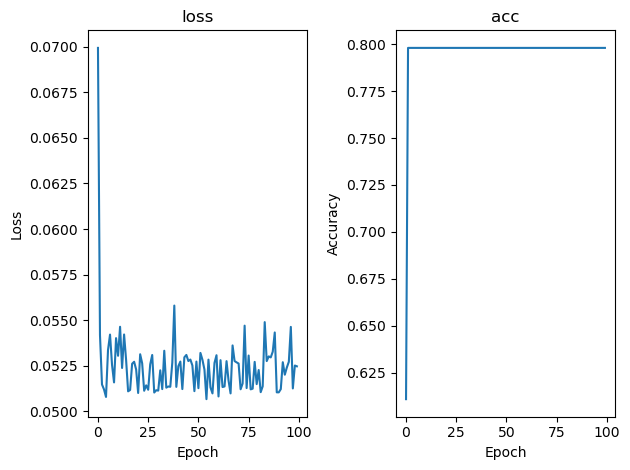

In [6]:
import matplotlib.pyplot as plt

metrics = metadata['metrics']

# losses
# plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('loss')

# accuracies
plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('acc')
plt.tight_layout()
plt.show()

# classification report

In [7]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

LABELS_MAP = ['0-NR', '1-R']
NUM_CLASSES = len(LABELS_MAP)

y_true = metadata['y_true']
y_logits = metadata['y_logits']
y_scores = metadata['y_scores'][:, 1] # get scores for class '1-R'
y_pred = metadata['y_pred']

print(classification_report(y_true, y_pred, labels=range(NUM_CLASSES), target_names=LABELS_MAP, zero_division=0))

              precision    recall  f1-score   support

        0-NR       0.75      1.00      0.86        65
         1-R       0.00      0.00      0.00        22

    accuracy                           0.75        87
   macro avg       0.37      0.50      0.43        87
weighted avg       0.56      0.75      0.64        87



# confusion matrix

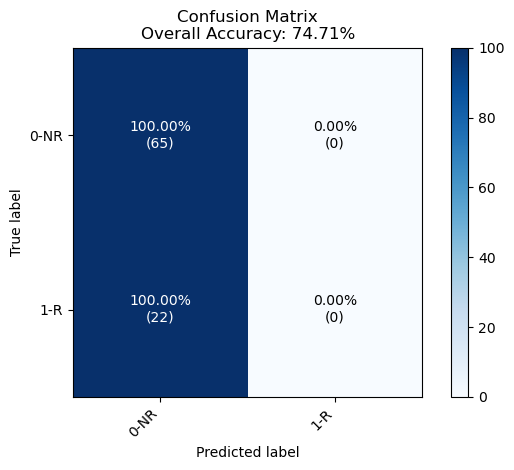

In [9]:
import numpy as np

# compute
cm_counts = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
cm_percent = 100*confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')
cm_percent = np.round(cm_percent, 2)

# plot
# plt.figure(figsize=(12, 10))
plt.imshow(cm_percent, cmap='Blues')
plt.title(f'Confusion Matrix\nOverall Accuracy: {100*(np.sum(y_true == y_pred)/len(y_true)):.2f}%')
plt.xticks(np.arange(NUM_CLASSES), LABELS_MAP, rotation=45, ha='right')
plt.yticks(np.arange(NUM_CLASSES), LABELS_MAP)
plt.colorbar()
plt.clim(0, 100)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# add %/counts
thresh = cm_percent.max() / 2.
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        percent = cm_percent[i, j]
        count = cm_counts[i, j]
        plt.text(j, i, f'{percent:.2f}%\n({count})', ha='center', va='center',
                color='white' if percent > thresh else 'black')

plt.tight_layout()
plt.show()

# # old method, no counts
# cm = 100*confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS_MAP)
# # plot on large figure
# fig, ax = plt.subplots(figsize=(20,20))
# disp.plot(xticks_rotation = 45, values_format = '.2f', ax=ax, cmap='Blues')
# plt.title('Confusion Matrix')
# plt.tight_layout()
# plt.show()

# roc curves

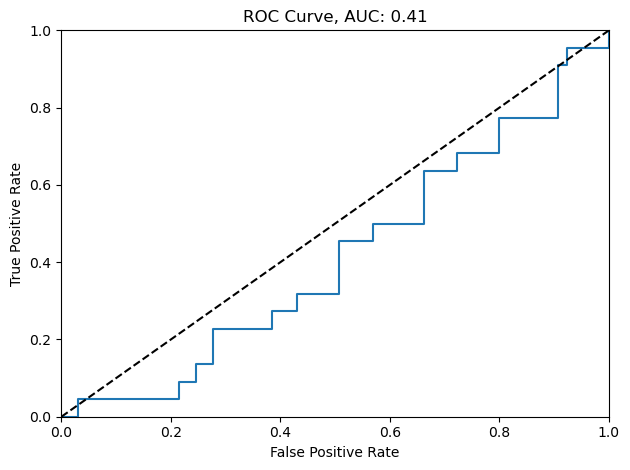

In [10]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve, AUC: {roc_auc:.2f}')
plt.tight_layout()
plt.show()

# old: one vs all roc

In [11]:
# # one vs all roc curves
# from sklearn.preprocessing import label_binarize
# from sklearn.metrics import roc_curve, auc

# # onehot encode labels
# y_true_onehot = label_binarize(y_true, classes=range(NUM_CLASSES))

# # roc for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(NUM_CLASSES):
#     fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_logits[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # macro/micro average
# # macro
# fpr['macro'] = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
# tpr['macro'] = np.zeros_like(fpr['macro'])
# for i in range(NUM_CLASSES):
#     tpr['macro'] += np.interp(fpr['macro'], fpr[i], tpr[i])
# tpr['macro'] /= NUM_CLASSES
# roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

# # micro
# fpr['micro'], tpr['micro'], _ = roc_curve(y_true_onehot.ravel(), y_logits.ravel())
# roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# # plot ROC curves
# plt.figure(figsize=(12, 10))
# plt.plot(fpr['macro'], tpr['macro'], label=f'Macro-average ROC curve (area = {roc_auc['macro']:.2f})', linestyle='--')
# plt.plot(fpr['micro'], tpr['micro'], label=f'Micro-average ROC curve (area = {roc_auc['micro']:.2f})', linestyle='--')
# for i in range(NUM_CLASSES):
#     plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {LABELS_MAP[i]} (area = {roc_auc[i]:.2f})')
# plt.plot([0, 1], [0, 1], 'k--')

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend()
# plt.tight_layout()
# plt.show()